# Logistic Regression Model for Heart Disease Prediction
This notebook builds and evaluates a Logistic Regression classifier on the heart disease dataset. It follows the same structure and style as the Random Forest and XGBoost notebooks, with clear code, visualizations, and markdown explanations.

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['teal', 'crimson'])
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
# Load data
data = pd.read_csv('../data/heart_featured.csv')
cat_cols = ['Sex', 'FastingBS', 'ExerciseAngina', 'ChestPainType', 'RestingECG', 'ST_Slope', 'LawChol', 'LawOldpeak']
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
target_col = 'HeartDisease'

## Data Splitting and Preprocessing
Logistic Regression requires all features to be numeric and scaled. We'll use one-hot encoding for categoricals and standard scaling for numericals.

In [3]:
# Split data
y = data[target_col]
X = data.drop(columns=[target_col])
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])
X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

## Logistic Regression Model Training and Hyperparameter Tuning
We'll use grid search with stratified K-fold cross-validation to tune the Logistic Regression classifier.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}
logreg = LogisticRegression(max_iter=1000, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(logreg, param_grid, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)
gs.fit(X_train_prep, y_train)

print(f'Best parameters: {gs.best_params_}')
print(f'Best CV accuracy: {gs.best_score_:.4f}')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV accuracy: 0.8566


Validation Accuracy: 0.8623188405797102
Classification Report:               precision    recall  f1-score   support

           0       0.85      0.84      0.85        62
           1       0.87      0.88      0.88        76

    accuracy                           0.86       138
   macro avg       0.86      0.86      0.86       138
weighted avg       0.86      0.86      0.86       138

Confusion Matrix: [[52 10]
 [ 9 67]]


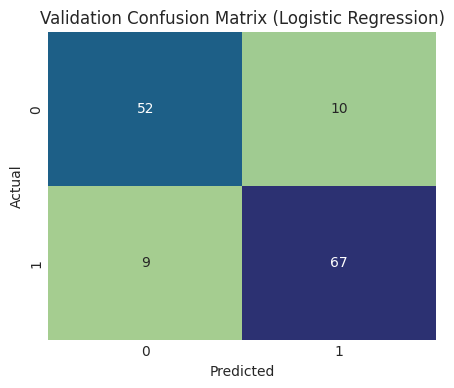

In [5]:
# Validation set evaluation
val_preds = gs.predict(X_val_prep)
print('Validation Accuracy:', accuracy_score(y_val, val_preds))
print('Classification Report:', classification_report(y_val, val_preds))
print('Confusion Matrix:', confusion_matrix(y_val, val_preds))

# Visualize confusion matrix
cm = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix (Logistic Regression)')
plt.show()

Test Accuracy: 0.8840579710144928
Classification Report:               precision    recall  f1-score   support

           0       0.88      0.85      0.87        62
           1       0.88      0.91      0.90        76

    accuracy                           0.88       138
   macro avg       0.88      0.88      0.88       138
weighted avg       0.88      0.88      0.88       138

Confusion Matrix: [[53  9]
 [ 7 69]]


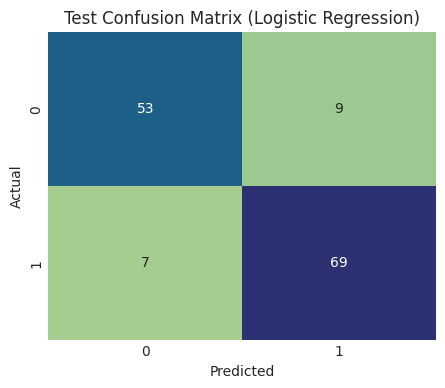

In [6]:
# Test set evaluation for Logistic Regression
test_preds = gs.predict(X_test_prep)
print('Test Accuracy:', accuracy_score(y_test, test_preds))
print('Classification Report:', classification_report(y_test, test_preds))
print('Confusion Matrix:', confusion_matrix(y_test, test_preds))

# Visualize confusion matrix
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix (Logistic Regression)')
plt.show()

In [7]:
# Save Logistic Regression model performance and feature importances to CSV
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
perf_rows = []
for split, X_, y_, preds in [
    ('validation', X_val_prep, y_val, val_preds),
    ('test', X_test_prep, y_test, test_preds),
    ]:
    perf_rows.append({
        'model': 'LogisticRegression',
        'split': split,
        'accuracy': accuracy_score(y_, preds),
        'precision': precision_score(y_, preds),
        'recall': recall_score(y_, preds),
        'f1': f1_score(y_, preds)
    })
perf_df = pd.DataFrame(perf_rows)
perf_df.to_csv('../data/model_performance.csv', mode='a', header=False, index=False)

# Save top 25 feature importances (absolute value of coefficients)
importances = np.abs(gs.best_estimator_.coef_[0])
feature_names = list(preprocessor.named_transformers_['num'].get_feature_names_out(num_cols)) + list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols))
dx = np.argsort(importances)[::-1]
fi_df = pd.DataFrame({
    'model': 'LogisticRegression',
    'feature': [feature_names[i] for i in dx[:25]],
    'importance': importances[dx[:25]]
})
fi_df.to_csv('../data/feature_importance.csv', mode='a', header=False, index=False)